# AS-AD-model with long-run growth and bubbles.

In the following, we analyze a basic AS-AD-model containing equilibria in the goods- and service markets,an inflation-targeting Taylor rule, short-run aggregate supply determined by a philips-curve with nominal wage rigidities, as well as rational expectations for inflation.

The model has been extended with exogenous growth in structural output, $\overline{y}$, in order to simulate an economy and nominal volatility around an underlying real growth.

The model has furthermore been extended with three types of chocks:
- Biased noise in the supply side of the economy resulting in negative correlation between inflation and output - the degree to which is decided by the tradeoff set in the Taylor-rule. We have made the Central Bank relatively averse of inflation-gaps from the target of 2 pct., setting a higher b-value than h.
- White noise in the demand side of the economy, however being almost completely neutralized by Central Bank monetary policy, thus not affecting the economy much.
- Risks of a bubble bursting if the economy is bullish, having a positive outputgap. Whenever this is the case, we have implemented a given risk of nominal GDP, $y_t$, dropping a certain relative amount in the supply-side of the economy. Say, a 0,4 pct. chance of $y_t$ falling by 20 pct. each period with a positive output-gap. 

We are interested in seeing the effects of crashes with a Central Bank following a given Taylor-rule.

The model has been calibrated for one period lasting around a week. For a 1000-period simulation this means around 20 years.

In [6]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import math
from sympy import symbols, Eq, solve
from scipy import optimize

## The Model: 

The long-run part of the model can be described by:
$$\tag{GROWTH} \overline{y}_t = \overline{y}_{t-1} + k$$
In which $k \sim N(\mu_g,\sigma^2_g)$ is a stochastic chock with drift $\mu_g$ and variance $\sigma^2_g$. Thus, the structural output grows exogenously over time. As a baseline we have sat $\sigma^2_g = 0$ in order to isolate short-run fluctuations from long run ones, and sat $\mu_g=0.0008$, as this growth-rate on a weekly basis leads to an annual growth of around 2,3 pct. 

The short-run part of the model can be described by:
$$ \tag{IS} y_t - \overline{y} = \alpha_1(g-\overline{g}) - \alpha_2(r-\overline{r}) - \alpha_3(\tau - \overline{\tau}) + d_t$$
$$ \tag{MP} i_t^p = \pi_{t+1}^e + \overline{r} + h(\pi - \pi^*) + b(y-\overline{y})$$
$$ \tag{AS} y_t - \overline{y} = \frac{1}{\gamma}(\pi - \pi^*) + \frac{v_t}{\gamma}$$
$$ \tag{IE} \pi^e_{t+1} = \pi_t^* $$
$$ \tag{FE} i_t^p - \pi_t = r_t $$

This results in the final model being solved by the system:
$$ \tag{AS} y_t - \overline{y} = \frac{1}{\gamma}(\pi - \pi^*) + \frac{v_t}{\gamma}$$

$$ \tag{AD} y_t - \overline{y} = -\frac{\alpha_2 h}{1+\alpha_2 b}(\pi_t-\pi^*) + \frac{\alpha_1}{1+\alpha_2 b}(g-\overline{g}) - \frac{\alpha_3}{1+\alpha_2 b}(\tau-\overline{\tau})+\frac{d_t}{1+\alpha_2 b}$$

$$ \tag{SC} v_{t} = v_{t-1}+x_t + c_t$$

$$ \tag{DC} d_{t} = d_{t-1} + z_t $$

Where:

$x_t \sim N(\mu_s,\sigma_s^2)$ is the supply-chock and $\mu_s$ is a drift of nominal short-run supply. This has been set to 0,001, greater than that of structural supply, in order to create an effect of nominally faster growth than the structural one, which consequently offsets the negative effects of bubble bursts.

$z_t \sim N(\mu_d,\sigma_s^2)$ is the white-noise demand-chock, having $\mu_d = 0$. 

$c_t \in \begin{cases}[-\rho y_t,0]  \hspace{2mm} \textrm{with probabilities} \hspace{2mm} [p, (1-p)]& \text{if } \hspace{2mm} (y_t-\overline{y}) > 0 \\
                      0                                    & \text{if } \hspace{2mm} (y_t-\overline{y})\le 0      
        \end{cases}$ 

is a stochastic crash-variable having risk of $p$ of reducing nominal supply each period with a positive output-gap.

Note, that all lower-case variables are logged - and differences are thus approximate percentages

In [2]:
#Defining exogenous variables:
alpha1 = 1 #Weight of public spending on consumption demand
alpha2 = 1 #Weight of real interest rate on consumption demand
alpha3 = 1 #Weight of taxation changes on consumption demand
gamma = 1.5 #Constant, philips
h = 1 #Central Banks inflation-rule
b = 0.5 #Central Banks output-rule
tau = 1 #Taxation
taubar = 1 #Baseline taxation
g = 1 #Public spending
gbar = 1 #Baseline public spending
ybar = 2 #Structural GDP
pibar = 2 #Inflation target
pi_exp = pibar #Inflationary expectations
p = 0.004 #Risk of crash each period
rho = 0.2 #Share of supply cut if crash
v = np.random.normal(loc=0.001, scale=0.01, size=None)#Noise with drift (SUPPLY) 

#Setting number of periods in simulation:
simsize = 1000



#Defining the time series:
data = pd.DataFrame()
data['tid'] = range(0,1000)


## Diagram 
Firstly, the model is set up for intuitive purposes, showing the AS-AD-diagram and correlation:

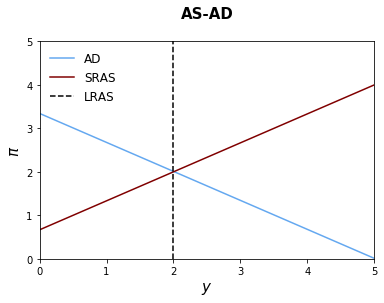

In [7]:
#Defining the functions:

def AS(ybar,pi,pi_exp,gamma):
    y = ybar + (1/gamma)*(pi-pi_exp)
    return y

def AD(ybar,pi,pibar,alpha1,g,gbar,alpha2,alpha3,h,b,tau,taubar):
    y = ybar + (alpha1/(1+alpha2*b))*(g-gbar) -(alpha2*h/(1+alpha2*b))*(pi-pibar) -(alpha3/(1+alpha2*b))*(tau-taubar) + (1/(1+alpha2*b))*v
    return y

#Solving the partial equilibria with the given values:
AS_liste = []
for i in range(0,10):
    AS_liste.append(AS(ybar,i,pi_exp,gamma))

AD_liste = []
for i in range(0,10):
    AD_liste.append(AD(ybar,i,pibar,alpha1,g,gbar,alpha2,alpha3,h,b,tau,taubar))


#Showing the AS-AD-diagram:
fig, ax1 = plt.subplots(figsize=(6,4))
plt.title('AS-AD',fontsize=15,weight='bold',pad=23)
goldman_blue = '#64a8f0'
plt.plot(AD_liste, label = 'AD', c=goldman_blue)
plt.plot(AS_liste, label = 'SRAS', c='maroon')
plt.axvline(pibar,linestyle='--',c='black', label = 'LRAS')


plt.xlabel('$y$',fontsize=15)
plt.ylabel('$\pi$',fontsize=15)

ax1.set_xlim(0,5)
ax1.set_ylim(0,5)


plt.legend(frameon=False,fontsize=12)

plt.savefig('AS-AD.pdf')

The above graph shows the correlation between dupply(SRAS) and demand(AD) in the short-run with equilibrium in ($\overline{y},\overline{\pi})=(2,2)$, that represents the long-run equilibrium.

## The Growth

Creating the underlying exogenous growth in structural GDP, not dwelving further into purpose of or reason for the source of growth:

In [8]:

#Created as a random walk with drift and zero variance as baseline:
drift = 0.0008
y_bar = [1]
for i in range(1,simsize):
    s = np.random.normal(loc=0,scale=0,size=None)
    y_bar.append(
        y_bar[i-1] + drift
    )
data['ybar'] = pd.DataFrame(y_bar)

## Simulation

The model is solved and simulated.

Note: it will take a couple of minutes to finish the simulation, since the model is solved in every iteration. This could have been avoided by creating a program that solved the model more efficiently.

In [13]:
#Setting a seed, 10:
np.random.seed(10)

#Setting baseline-values and defining lists of solved values to later graph:
y_løsninger = []
pi_løsninger = []
v_vektor = [0]
d_vektor = [0]
c = 0
gab = [0]
crises = []

#Solving the AS-AD-model with regards to inflation and output by a for-loop:
for i in range(1,simsize):

    #Creating a stochastic chocks in both supply- and demand-side of economy in every iteration:
    v = np.random.normal(loc=0.001, scale=0.01, size=None) #Noise with drift (SUPPLY)
    d = np.random.normal(loc=0, scale=0.01, size=None) #White noise (DEMAND)
    v_vektor.append(
            v_vektor[i-1] + v + c
            )
    d_vektor.append(
        d_vektor[i-1] + d
    )

#Solving the model using optimizer from scipy:
    pi, y = symbols('pi y')
    obj1 = lambda pi, y : data['ybar'][i] + (1/gamma)*(pi-pi_exp) + (v_vektor[i])/gamma - y
    obj2 = lambda pi, y : data['ybar'][i] + (alpha1/(1+alpha2*b))*(g-gbar) -(alpha2*h/(1+alpha2*b))*(pi-pibar) -(alpha3/(1+alpha2*b))*(tau-taubar) + (1/(1+alpha2*b)*d_vektor[i] - y)
    obj  = lambda x : [obj1(x[0],x[1]),obj2(x[0],x[1])]
    sol = optimize.root(obj,x0= [pibar,ybar])
    løsning = {y:sol.x[1],pi:sol.x[0]}
    
    gab.append(løsning[y]-data['ybar'][i])

    #risk of crash.
    if gab[i] > 0:
        #c = np.random.choice(a=[0,100],p=(1-(gab[i]**2)*0.177,(gab[i]**2)*0.177)) Alternative crash, size-dependent on output-gap
        c = np.random.choice(a=[0,-løsning[y]*rho],p=(1-p,p))
        crises.append(c)
    else:
        c=0

#Appending realisations of the model:
    pi_løsninger.append(løsning[pi])
    y_løsninger.append(løsning[y])
    pi_exp = løsning[pi]

data['y_løs'] = pd.DataFrame(y_løsninger)
data['pi_løs'] = pd.DataFrame(pi_løsninger)



#Calculating inflationary- and output-gaps:
outputgab = [0]
for i in range(1,len(data['y_løs'])):
    outputgab.append(data['y_løs'][i] - data['ybar'][i])

inflationgab = [0]
for i in range(1,len(data['pi_løs'])):
    inflationgab.append(data['pi_løs'][i] - pibar)

data['outputgab'] = outputgab
data['inflationgab'] = inflationgab


1000 999 1000


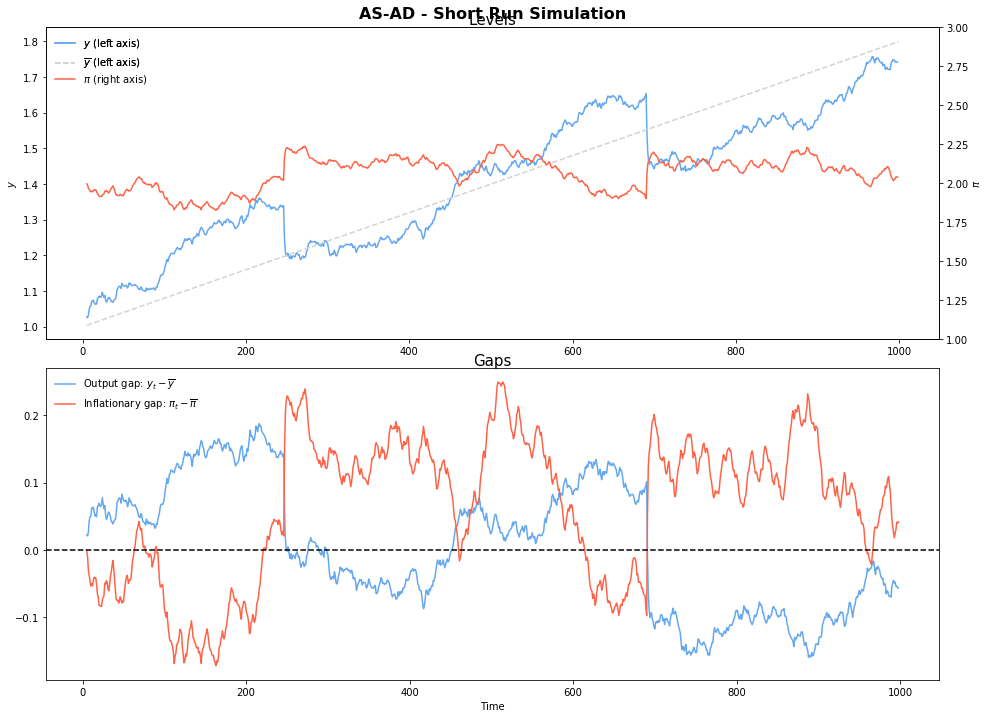

In [14]:
#Setting up the figure:
fig = plt.figure(figsize=(16,12), frameon=False)
title_font = {'size':'16', 'color':'black', 'weight':'bold',
              'verticalalignment':'bottom'}
plt.title('AS-AD - Short Run Simulation',**title_font)
plt.axis('off')

#Figure 1
ax = fig.add_subplot(4,1,(1,2))
plt.title('Levels',fontsize=15,weight='normal',pad=-20)
plt.plot(data['y_løs'][5:], label = '$y$ (left axis)',c=goldman_blue)
plt.plot(data['ybar'][5:], label = '$\overline{y}$ (left axis)', c='lightgrey', linestyle='--')
plt.ylabel('$y$')
legend1 = plt.legend(loc = 'upper left', frameon=False)

ax2 = ax.twinx()
plt.plot(data['pi_løs'][5:], label = '$\pi$ (right axis)',c='tomato')
plt.tick_params()
plt.ylabel('$\pi$', )
legend2 = plt.legend(loc = 'upper left', frameon=False,bbox_to_anchor=(0,0.885))
ax.add_artist(legend1)
ax2.set_ylim(1,3)


#Figure 2:
ax = fig.add_subplot(4,1,(3,4))
plt.title('Gaps',fontsize=15,weight='normal',pad=-20)
plt.plot(data['outputgab'][5:], label = 'Output gap: $y_t - \overline{y}$',c=goldman_blue)
plt.plot(data['inflationgab'][5:], label = 'Inflationary gap: $\pi_t - \overline{\pi}$',c='tomato')
ax.axhline(0,linestyle='--',c='black')
plt.legend(frameon=False,loc='upper left',bbox_to_anchor=(0,1))
plt.xlabel('Time')


plt.savefig('Simulation.pdf')
print(len(v_vektor),len(y_løsninger),len(data['y_løs']))

In [15]:
#printing descriptive statistics of the second graph.
print('The mean of the inflationary gap')
print(data['inflationgab'].mean())
print('The standard deviation of inflationary gap')
print(data['inflationgab'].std())
print('The mean of the output gap')
print(data['outputgab'].mean())
print('The standard deviation of output gap')
print(data['outputgab'].std())

#correlation between inflationary gap and output gap:
#correlation = data['outputgab'].corr(data['inflationgab'])


The mean of the inflationary gap
0.06377045294937161
The standard deviation of inflationary gap
0.10493075628627888
The mean of the output gap
0.0050212492615558865
The standard deviation of output gap
0.09403345656070142


In [16]:
from scipy.stats import pearsonr
data1=data.copy()
data1.dropna(inplace=True)
print('The correlation between the two gaps are:')
print(pearsonr(data1['outputgab'],data1['inflationgab'])[0])

The correlation between the two gaps are:
-0.7291005797863483


## Interpretation

- First of all, we see a relatively realistic cycle - although with unrealistically sudden one-period crashes. It is seen, that nominal GDP, $y_t$, tends to grow slightly faster than its structural counterpart, $\overline{y}$, however being neutralized by the bubble-bursts regularly.

- Secondly, we see a relatively stable inflation between 1,8 and 2,2 pct. (the target rate being 2), due to a relatively inflationary-conservative Central Bank. We opted for one of the heavy-weights, Paul Volcker.

- Thirdly, we see very - but not perfectly(!) - inversely correlated inflation and output. This is due to the supply-chocks hitting the economy harder (with a perfectly inversely correlated change between inflation and output, of which the relative sizes are decided by the slope of the AD-curve, as decied by the Central Banks trade-off in the Taylor-rule). Demand-chocks can to a certain degree be perfectly smoothed out by the Central Bank through monetary policy, which is why demand-chocks, although present, not affect the economy much. This is, however, the reason for a not *perfect* inverse correlation between the two variables.

- Fourth, this iteration has resulted in two large bubble-bursts over the twenty-year period, both of which result in a 20 pct. cut in output, followed by steady convergence back towards the trend.

- Fifth, the economy seems to grow around $ln(1,8) \approx 58$ pct. over the period of 1000 weeks, around 20 years, equivalent of $1,58^{\frac{1}{20}} - 1 \approx 2,3$ pct. per year. This seems realistic and consistent with other empirical findings in Western world.

- From the descriptive statistics we lastly conclude that the correlation between the inflationary and output gap is negative, which correpsonds with the graph and is based on the definition of the demand.

## Conclusion

The model has resulted in a relatively realistically-looking simulation of real-world business-cycles, however having its flaws, some of which have been mentioned througout the text.